In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
plt.style.use('dark_background') 

def highlight_odd_rows(s):
    styles = []
    for i in range(len(s)):
        if i % 2 == 1:
            styles.append('background-color: indigo; border: 1px solid white;')
        else:
            styles.append('border: 1px solid white;')
    return styles

In [3]:
df = pd.read_csv("consultassec.csv")

In [4]:
df.head().style.apply(highlight_odd_rows)

,VIN,_id,host,ip,apiKey,userId,idReporte,requestParameters,requestUrl,responseCode,responseCodeStatus,requestTime,responseTime,labels,idRespuesta,idConsulta,responseBody,carfaxUsaData,alertas,firewallUsa
0,1FTCR1002MUC67747,672a4446124bd56498eadd97,10.240.2.38:80,"201.116.128.213:25288,10.240.5.208, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,nan,nan,{},/v2/regularizacion/1FTCR1002MUC67747,200,ok,5/11/2024 10:13:58,5/11/2024 10:14:00,nan,672a4448124bd56498eadd98,672a4446124bd56498eadd97,"{""mensajes"":[{""codigo"":4,""mensaje"":""El dígito verificador en la 9° posición del VIN 1FTCR1002MUC67747 NO es correcto.""}],""marca"":""FORD"",""modelo"":""RANGER"",""anioModelo"":""1991"",""robo"":false,""roboFecha"":null,""fabricante"":""FORD MOTOR COMPANY"",""paisOrigen"":""ESTADOS UNIDOS (USA)"",""tiempoConsulta"":""2024-11-05T10:13:58-06:00"",""tiempoRespuesta"":""2024-11-05T10:14:00-06:00""}","{""error"":""VIN INVALIDO"",""respuestaCompleta"":{""vin"":""1FTCR1002MUC67747"",""timestamp"":""2024-11-05T10:13:58.000"",""error"":{""message"":""The VIN you entered was invalid""},""vinSuggestions"":[{""vin"":""1FTCR10U2MUC67747"",""description"":""1991 FORD/RANGER CUSTOM/3.0L V6 F""},{""vin"":""1FTEX1CP2MKC67747"",""description"":""2021 FORD/F150 SUPER CAB/2.7L V6 F DOHC 24V""},{""vin"":""1FTRS4UG2MKC67747"",""description"":""2021 FORD/TRANSIT T-350 HD/3.5L V6""}]}}","[{""codigo"":4,""mensaje"":""El dígito verificador en la 9° posición del VIN 1FTCR1002MUC67747 NO es correcto.""}]",0
1,KL8CB6SA6HC706067,672a44417384826621095dcd,10.240.2.38:80,"201.116.128.213:25288,10.240.5.208, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,nan,nan,{},/v2/regularizacion/KL8CB6SA6HC706067,200,ok,5/11/2024 10:13:53,5/11/2024 10:13:56,nan,672a44447384826621095dce,672a44417384826621095dcd,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""marca"":""CHEVROLET"",""modelo"":""SPARK LS CVT"",""anioModelo"":""2017"",""fabricante"":""GENERAL MOTORS LLC"",""paisOrigen"":""COREA DEL SUR"",""tiempoConsulta"":""2024-11-05T10:13:53-06:00"",""tiempoRespuesta"":""2024-11-05T10:13:56-06:00""}","{""vin"":""KL8CB6SA6HC706067"",""timestamp"":""2024-11-05T10:13:53.000"",""components"":{""potentialFraudFile"":{""year"":2017,""make"":""CHEVROLET"",""model"":""SPARK LS CVT"",""rateEvasionFlags"":[],""potentialFraudFlags"":[],""vinCloningFlags"":[]}},""customCalculationOdometer"":""""}",[],0
2,1HGCR2F33DA191155,672a443f69994fdacd6fe53c,10.240.2.38:80,"201.116.128.213:25287,10.240.6.41, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,nan,nan,{},/v2/regularizacion/1HGCR2F33DA191155,200,ok,5/11/2024 10:13:51,5/11/2024 10:13:54,nan,672a444269994fdacd6fe53d,672a443f69994fdacd6fe53c,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""marca"":""HONDA"",""modelo"":""ACCORD LX"",""anioModelo"":""2013"",""fabricante"":""AMERICAN HONDA MOTOR CO., INC."",""paisOrigen"":""ESTADOS UNIDOS (USA)"",""tiempoConsulta"":""2024-11-05T10:13:51-06:00"",""tiempoRespuesta"":""2024-11-05T10:13:54-06:00""}","{""vin"":""1HGCR2F33DA191155"",""timestamp"":""2024-11-05T10:13:52.000"",""components"":{""potentialFraudFile"":{""year"":2013,""make"":""HONDA"",""model"":""ACCORD LX"",""rateEvasionFlags"":[],""potentialFraudFlags"":[],""vinCloningFlags"":[]}},""customCalculationOdometer"":""""}",[],0
3,5TBRT34123S422249,672a44357384826621095dcb,10.240.2.38:80,"201.116.128.213:25286,10.240.3.57, 127.0.0.6",6cNqbbTqBnZEchPZ2YYn,nan,nan,{},/v2/regularizacion/5TBRT34123S422249,200,ok,5/11/2024 10:13:41,5/11/2024 10:13:42,nan,672a44367384826621095dcc,672a44357384826621095dcb,"{""mensajes"":[],""robo"":false,""roboFecha"":null,""marca"":""TOYOTA"",""modelo"":""TUNDRA SR5"",""anioModelo"":""2003"",""fabricante"":""TOYOTA MOTOR MANUFACTURING, INDIANA, INC."",""paisOrigen"":""ESTADOS UNIDOS (USA)"",""tiempoConsulta"":""2024-11-05T10:13:41-06:00"",""tiempoRespuesta"":""2024-11-05T10:13:42-06:00""}","{""vin"":""5TBRT34123S422249"",""timestamp"":""2024-11-05T10:13:41.000"",""components"":{""potentialFraudFile"":{""year"":2003,""make"":""TOYOTA"",""model"":""TUNDRA S

In [5]:
def getDfSize(df):
    rows = len(df.axes[0])
    columns = len(df.axes[1])

    return {'rows': rows, 'columns': columns}

In [6]:
getDfSize(df)

{'rows': 1000, 'columns': 20}

<h3>La siguiente función extrae las distintas llaves de cada diccionario que contenga una columna como valor en el dataframe</h3>

In [8]:
def determineDistinctKeys(columnToList): #Recibe una lista, no una dataframe column
    distinctKeysDict = {}
    distinctKeysList = []
    for dictionary in columnToList:
        dictionary = json.loads(dictionary)
        orderedKeys = sorted(list(dictionary.keys()))
        if orderedKeys in distinctKeysList:
            distinctKeysDict['/'.join(orderedKeys)] += 1
        else:
            distinctKeysList.append(orderedKeys)
            distinctKeysDict['/'.join(orderedKeys)] = 0
    return distinctKeysDict

<h3>La siguiente función extrae los distintos valores de una columna en el dataframe</h3>

In [10]:
def determineDistinctValues(df, col): #Recibe el dataframe y la columna del dataframe que requiere ser revisado
    return df[col].unique()

<h3>Con esto sabemos que la columna "Response Body" tiene un cuerpo idéntico para todos los casos</h3>

In [12]:
responseBody = df['responseBody'].values.tolist()

In [13]:
determineDistinctKeys(responseBody)

{'anioModelo/fabricante/marca/mensajes/modelo/paisOrigen/robo/roboFecha/tiempoConsulta/tiempoRespuesta': 999}

<h3>Con esto sabemos la proporción entre consultas con algún tipo de error, o consultas normales en Carfax  USA</h3>

In [15]:
carfaxUsaData = df['carfaxUsaData'].values.tolist()

In [16]:
determineDistinctKeys(carfaxUsaData)

{'error/respuestaCompleta': 96,
 'components/customCalculationOdometer/timestamp/vin': 896,
 'VHR/components/customCalculationOdometer/timestamp/vin': 5}

<h3>Finalmente sabemos qué se pide en los "Request Parameters"</h3>

In [18]:
requestParameters = df['requestParameters'].values.tolist()

In [19]:
determineDistinctKeys(requestParameters)

{'': 999}

<h3>Ahora nos aseguramos de todos los valores distintos que haya en las columnas</h3>

In [21]:
determineDistinctValues(df, 'apiKey') #Solo existe un valor posible para este campo

array(['6cNqbbTqBnZEchPZ2YYn'], dtype=object)

In [22]:
determineDistinctValues(df, 'userId') #Solo existe un valor posible para este campo

array([nan])

In [23]:
determineDistinctValues(df, 'idReporte') #Existen varios valores (¿de qué depende esta diferencia?)

array([nan, '672a3b750745c07a84447ca3', '6729ba00ad3afe28335abe96',
       '6729a7fcac983ba428577605', '6729a7fb3ca0aa5d954b7438',
       '6729a7f5a039203ff6d89a3a', '6729a559d3e227a133728861'],
      dtype=object)

In [24]:
determineDistinctValues(df, 'responseCode') #Solo existe un valor posible para este campo

array([200])

In [25]:
determineDistinctValues(df, 'responseCodeStatus') #Solo existe un valor posible para este campo

array(['ok'], dtype=object)

In [26]:
determineDistinctValues(df, 'labels') #Solo existe un valor posible para este campo

array([nan])

In [27]:
determineDistinctValues(df, 'firewallUsa') #Solo existe un valor posible para este campo

array([0])

<h3>A continuación busco los distintos tipos de código de alerta que se encuentran en el dataframe creando una función especial para ello </h3>

In [29]:
def countAlertCodes(df, alertsColumn: str):
    alertsWithCode = list(determineDistinctValues(df, alertsColumn))
    codeCount = {'Code 1': 0 , 'Code 2': 0, 'Code 3': 0, 'Code 4': 0, 'Code 5': 0, 'Code 6': 0, 'Code 7': 0}

    for alert in alertsWithCode:
        alertList = json.loads(alert)
        if alertList != []:
            for subalert in alertList:
                n = subalert['codigo']
                codeCount[''.join(['Code ', str(n)])] += 1

    return codeCount #El resultado me dará el código de error más frecuente en la plataforma


In [30]:
countAlertCodes(df, 'alertas')

{'Code 1': 11,
 'Code 2': 0,
 'Code 3': 3,
 'Code 4': 58,
 'Code 5': 1,
 'Code 6': 4,
 'Code 7': 5}

<h3>Ahora calculo el tiempo en que se tarda cada petición en generar una respuesta</h3>

In [32]:
def calculateDeltaTime(df, columnA, columnB):
    responseTimeType = pd.to_datetime(df[columnA])
    requestTimeType = pd.to_datetime(df[columnB])
    responsePeriod = (responseTimeType - requestTimeType).to_frame()
    responsePeriod['secondsDifference'] = pd.to_timedelta(responsePeriod[0]).dt.total_seconds()
    responsePeriod.drop([0], axis='columns', inplace=True)

    return responsePeriod

<h4>Con mayor frecuencia parece tardarse un segundo la respuesta. La gráfica parece ajustarse a una distribución de Poisson o a una distribución normal. Checar cuál es la más conveniente para calcular probabilidades</h4>

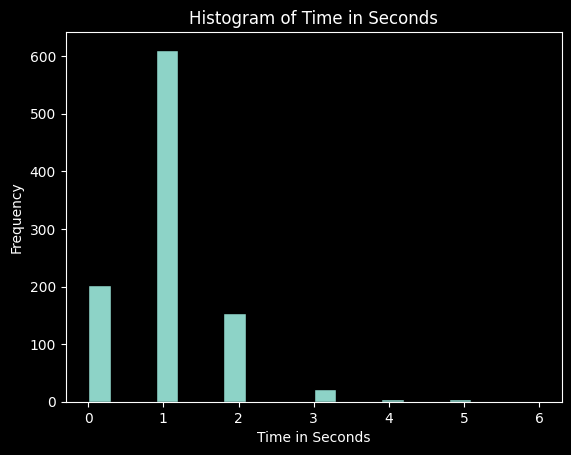

In [34]:
plt.hist(calculateDeltaTime(df, 'responseTime', 'requestTime')['secondsDifference'], bins = 20, edgecolor = 'black')
plt.xlabel('Time in Seconds')
plt.ylabel('Frequency')
plt.title('Histogram of Time in Seconds')
plt.show()

<h3>A continuación se comprueba que cada diccionario del valor de la columna carfaxUsaData con una llave "error" le corresponda un valor distinto a lista vacía</h3>

In [36]:
def proveErrorAlert(df):
    carfaxUsaData = df['carfaxUsaData'].values.tolist()
    conError = 0
    for index1 in range(len(carfaxUsaData)):
        carfaxDict = json.loads(carfaxUsaData[index1])
        if 'error' in list(carfaxDict.keys()):
            conError += 1
            if df.iloc[index1]['alertas'] == []:
                return 'Existe un valor con error y sin alerta'
    return 'Funciona correctamente'

In [37]:
proveErrorAlert(df)

'Funciona correctamente'

<h3>Ahora se estudiará la relación con los Vin's repetidos y las alertas</h3>

In [39]:
#The next function identifies the repeated values of a column

def getRepeatedValuesInAColumn(df, columnName):
    duplicates = df[df.duplicated(subset=[columnName], keep=False)]
    return duplicates['VIN']

In [40]:
def searchValuesInADataframe(values:list, columnA: str, columnB: str, df)-> dict:
    '''
    Searches the values of a list in a dataframe columnA and retrieves the information of columnB
    Args:
       values (list): The list of values to be searched
       columnA (string): The name's column to search
       columnB (string): The name's column to retrieve values
       df (pandas dataFrame): The dataframe where where will be searched
    Returns:
      valuesBDict (dict): A dictionary of values as key and the retrieved values of columnB as values
    '''
    
    valuesBDict ={}
    for value in values:
        valuesB = df.loc[df[columnA]== value, columnB].tolist()
        valuesBDict[value] = valuesB
    return valuesBDict

<h4>Identificamos si existe algún VIN repetido que contenga y a la vez no, mensajes de alerta. Además se identifica la cantidad de veces que se repiten los VIN's que lanzan alerta contra los que no lanzan ninguna alerta</h4>

In [42]:
def getIncorrectVinInformation(df):
    repeatedRows = len(getRepeatedValuesInAColumn(df, 'VIN').values.tolist())
    vinValues = getRepeatedValuesInAColumn(df, 'VIN').unique().tolist()
    repeatedVins = len(vinValues)
    repeatedValues = searchValuesInADataframe(vinValues, 'VIN', 'alertas', df)
    goodVins = 0
    badVins = 0
    goodVinsList = []
    badVinsList = []
    for repeatedVin in list(repeatedValues.keys()):
        differentValuesByVin = list(set(repeatedValues[repeatedVin]))
        for differentValue in differentValuesByVin:
            if differentValue == '[]':
                goodVins += 1
                if len(differentValuesByVin)>1:
                    return {message: ''.join(['Alerta con vin: ',repeatedVin, ' , tiene y no tiene alertas.']),
                           'goodVinsList': [],
                           'badVinsList': [],
                           'goodVins':0,
                           'badVins': 0}
                else:
                    goodVinsList.append([repeatedVin, len(repeatedValues[repeatedVin])])
            else:
                badVins += 1
                badVinsList.append([repeatedVin, len(repeatedValues[repeatedVin])])
            

    return {'message': ''.join(['VINs repetidos que no lanzan alerta: ', str(goodVins), '\nVINs repetidos que sí lanzan alerta: ', str(badVins)]),
           'goodVinsList': goodVinsList,
           'badVinsList': badVinsList,
           'goodVins':goodVins,
           'badVins': badVins}

In [43]:
def diagnoseVins(df):
    goodVinsFrame = pd.DataFrame(getIncorrectVinInformation(df)['goodVinsList'], columns = ['VIN', 'repeatedTimes'])
    goodRepeatedRecords = goodVinsFrame.sum()['repeatedTimes']
    badVinsFrame = pd.DataFrame(getIncorrectVinInformation(df)['badVinsList'], columns = ['VIN', 'repeatedTimes'])
    badRepeatedRecords = badVinsFrame.sum()['repeatedTimes']

    return {'goodVinsFrame': goodVinsFrame, 'badVinsFrame': badVinsFrame, 'goodRepeatedRecords': goodRepeatedRecords, 'badRepeatedRecords': badRepeatedRecords}

In [44]:
diagnoseVins(df)['goodVinsFrame'].describe().style.apply(highlight_odd_rows)

,repeatedTimes
count,127.000000
mean,4.094488
std,5.016533
min,2.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,33.000000


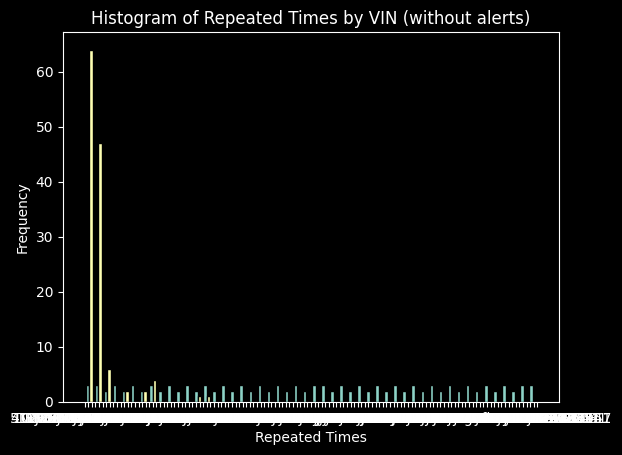

In [45]:
plt.hist(diagnoseVins(df)['goodVinsFrame'], bins = 50, edgecolor = 'black')
plt.xlabel('Repeated Times')
plt.ylabel('Frequency')
plt.title('Histogram of Repeated Times by VIN (without alerts)')
plt.show()

In [56]:
diagnoseVins(df)['badVinsFrame'].describe()

,repeatedTimes
count,16.000000
mean,2.687500
std,0.873212
min,2.000000
25%,2.000000
50%,2.500000
75%,3.000000
max,5.000000


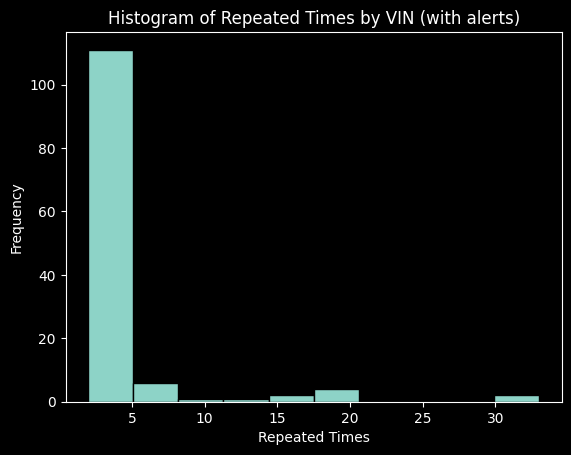

In [60]:
plt.hist(diagnoseVins(df)['goodVinsFrame']['repeatedTimes'], bins =10, edgecolor = 'black')
plt.xlabel('Repeated Times')
plt.ylabel('Frequency')
plt.title('Histogram of Repeated Times by VIN (with alerts)')
plt.show()

<h4>Finalmente tenemos los VINs revisados en todos los registros. La proporción entre VINs repetidos con alerta, VINs repetidos sin alerta. Máximos y mínimos repeticiones</h4>

Cantidad de registros repetidos:  563
Cantidad de registros repetidos con VINs sin alerta:  520
Cantidad de registros repetidos con VINs con alerta:  43
Cantidad de VINs revisados en esos registros repetidos:  143


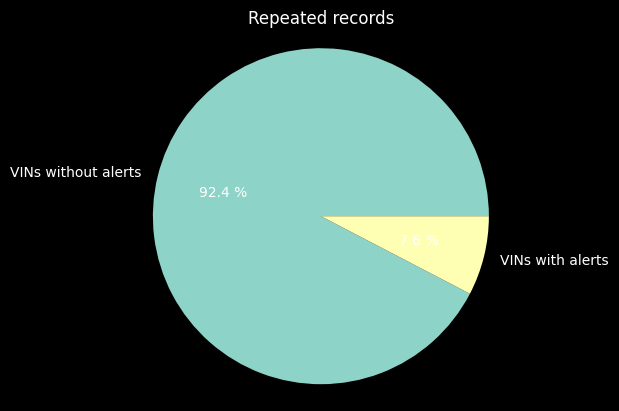

In [67]:
print('Cantidad de registros repetidos: ', diagnoseVins(df)['goodRepeatedRecords'] + diagnoseVins(df)['badRepeatedRecords'])
print('Cantidad de registros repetidos con VINs sin alerta: ', diagnoseVins(df)['goodRepeatedRecords'])
print('Cantidad de registros repetidos con VINs con alerta: ', diagnoseVins(df)['badRepeatedRecords'])
print('Cantidad de VINs revisados en esos registros repetidos: ', list(diagnoseVins(df)['badVinsFrame'].count() + diagnoseVins(df)['goodVinsFrame'].count())[1])
repetitionProportion = [diagnoseVins(df)['goodRepeatedRecords'], diagnoseVins(df)['badRepeatedRecords']]
labelsRepetition = ['VINs without alerts', 'VINs with alerts']
plt.pie(repetitionProportion, labels=labelsRepetition, autopct="%0.1f %%")
plt.axis("equal")
plt.title('Repeated records')
plt.show()

<h4>Estadísticas de las repeticiones de los VINs sin alerta</h4>

In [70]:
diagnoseVins(df)['goodVinsFrame'].describe().style.apply(highlight_odd_rows)

,repeatedTimes
count,127.000000
mean,4.094488
std,5.016533
min,2.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,33.000000


<h4>Estadísticas de las repeticiones de los VINs con alerta</h4>

In [73]:
diagnoseVins(df)['badVinsFrame'].describe().style.apply(highlight_odd_rows)

,repeatedTimes
count,16.000000
mean,2.687500
std,0.873212
min,2.000000
25%,2.000000
50%,2.500000
75%,3.000000
max,5.000000


<h3>Ahora se comprueba que para cada VIN repetido y sin alerta se dió exactamente la misma información</h3>

<h3>Ahora se comprueba que para cada VIN repetido y con alerta se dió exactamente la misma información y los mismos códigos de alerta</h3>

<h3>Ahora se analizan una parte de los datos mediante un periodo de tiempo n variable que extrae un subconjunto del dataframe </h3>

<h4>Primero se ordenan los datos de manera descendente por el campo "responseTime"</h4>

In [81]:
df = df.sort_values(by = 'responseTime', ascending = False)

In [83]:
df['responseTime'] = pd.to_datetime(df['responseTime'], format='%d/%m/%Y %H:%M:%S')
n_minutes  = 10
first_timestamp = df['responseTime'].iloc[0]
time_threshold = first_timestamp - pd.Timedelta(minutes=n_minutes)
filtered_df = df[df['responseTime'] >= time_threshold]
print(filtered_df.shape)

(75, 20)
